# China v. USA: A Comparison

For this notebook I will be exploring various different data points collected on China and the USA by reputable sources and comparing the growth of each country.

The data used in this notebook is sourced form the [World Bank World Development Index](https://datacatalog.worldbank.org/dataset/world-development-indicators) data set. Download the CSV data and place it in this location: `usa-v-china/data/WDI_csv/WDIData.csv`.

## Initialisation

In [1]:
import pandas as pd
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.ticker import EngFormatter
from matplotlib.colors import LinearSegmentedColormap

Now we load and visually inspect the data.

In [2]:
data = pd.read_csv('data/WDI_csv/WDIData.csv')

print(data.head())

  Country Name Country Code  \
0   Arab World          ARB   
1   Arab World          ARB   
2   Arab World          ARB   
3   Arab World          ARB   
4   Arab World          ARB   

                                      Indicator Name     Indicator Code  1960  \
0  Access to clean fuels and technologies for coo...     EG.CFT.ACCS.ZS   NaN   
1            Access to electricity (% of population)     EG.ELC.ACCS.ZS   NaN   
2  Access to electricity, rural (% of rural popul...  EG.ELC.ACCS.RU.ZS   NaN   
3  Access to electricity, urban (% of urban popul...  EG.ELC.ACCS.UR.ZS   NaN   
4  Account ownership at a financial institution o...     FX.OWN.TOTL.ZS   NaN   

   1961  1962  1963  1964  1965  ...       2011       2012       2013  \
0   NaN   NaN   NaN   NaN   NaN  ...  82.783289  83.120303  83.533457   
1   NaN   NaN   NaN   NaN   NaN  ...  86.428272  87.070576  88.176836   
2   NaN   NaN   NaN   NaN   NaN  ...  73.942103  75.244104  77.162305   
3   NaN   NaN   NaN   NaN   NaN  .

The first thing I notice here is the structure of the data. Each row appears to be a data point for a given indicator and country. The columns consist of relevant information such as the idicator code followe by one column for each year. This is not the format that pandas supports so we must restruture the data first before we can analse and plot it.

Also, the value of the `Country Name` field in the first rows is `Arab World`. Clearly this is not a country name and suggests the data is using some other classification groups.

In [3]:
print(data['Country Name'].unique())

['Arab World' 'Caribbean small states' 'Central Europe and the Baltics'
 'Early-demographic dividend' 'East Asia & Pacific'
 'East Asia & Pacific (excluding high income)'
 'East Asia & Pacific (IDA & IBRD countries)' 'Euro area'
 'Europe & Central Asia' 'Europe & Central Asia (excluding high income)'
 'Europe & Central Asia (IDA & IBRD countries)' 'European Union'
 'Fragile and conflict affected situations'
 'Heavily indebted poor countries (HIPC)' 'High income' 'IBRD only'
 'IDA & IBRD total' 'IDA blend' 'IDA only' 'IDA total'
 'Late-demographic dividend' 'Latin America & Caribbean'
 'Latin America & Caribbean (excluding high income)'
 'Latin America & the Caribbean (IDA & IBRD countries)'
 'Least developed countries: UN classification' 'Low & middle income'
 'Low income' 'Lower middle income' 'Middle East & North Africa'
 'Middle East & North Africa (excluding high income)'
 'Middle East & North Africa (IDA & IBRD countries)' 'Middle income'
 'North America' 'Not classified' 'OECD me

In [4]:
all_countries = data['Country Name'].unique()[47:]
countries_data = data.loc[data['Country Name'].isin(all_countries)]

print(countries_data.head())

      Country Name Country Code  \
67163  Afghanistan          AFG   
67164  Afghanistan          AFG   
67165  Afghanistan          AFG   
67166  Afghanistan          AFG   
67167  Afghanistan          AFG   

                                          Indicator Name     Indicator Code  \
67163  Access to clean fuels and technologies for coo...     EG.CFT.ACCS.ZS   
67164            Access to electricity (% of population)     EG.ELC.ACCS.ZS   
67165  Access to electricity, rural (% of rural popul...  EG.ELC.ACCS.RU.ZS   
67166  Access to electricity, urban (% of urban popul...  EG.ELC.ACCS.UR.ZS   
67167  Account ownership at a financial institution o...     FX.OWN.TOTL.ZS   

       1960  1961  1962  1963  1964  1965  ...       2011       2012  \
67163   NaN   NaN   NaN   NaN   NaN   NaN  ...  22.330000  24.080000   
67164   NaN   NaN   NaN   NaN   NaN   NaN  ...  43.222019  69.100000   
67165   NaN   NaN   NaN   NaN   NaN   NaN  ...  29.572881  60.849156   
67166   NaN   NaN   NaN   

## Setup

In [5]:
# ensure consistent coloring of countries in the notebook
COLOR_DICT = {
    'China': '#ff0000',
    'United States': '#0000ff',
    'United Kingdom': '#00df00',
    'Germany': '#ffce00',
    'France': '#ff33cc',
    'Italy': '#009933',
    'Japan': '#00ffff',
    'Saudi Arabia': '#006c34',
    'India': '#ff9933',
    'Korea, Rep.': '#be03fc'
}

DEFAULT_COUNTRIES = ["CHN", "USA"]
DEFAULT_YEARS = list(map(lambda x: str(x), range(1960, 2019 + 1)))

# reshape data to have years as rows and countries as columns within a specified range
def get_reshaped_dataframe(ind_code, countries, years):
    dataframes = {}
    
    # get rows for each country
    for country in countries:
        row = countries_data.loc[(countries_data['Country Code'] == country) & (countries_data['Indicator Code'] == ind_code)]
        dataframes[row['Country Name'].iloc[0]] = row
    
    # concat each row into single data frame
    joined_df = pd.concat(dataframes, ignore_index=True).set_index('Country Name')
    joined_df.index.name = None
    
    indicator_name = joined_df['Indicator Name'].iloc[0]

    # only plot data that is present
    available_years = [year for year in years if year in joined_df.columns]
    joined_df = joined_df[available_years].transpose()

    joined_df = joined_df.set_index(pd.to_datetime(joined_df.index))
    
    return (indicator_name, joined_df)

def get_indicator_change(ind_code, countries, years, use_percentage):
    (indicator_name, df) = get_reshaped_dataframe(ind_code, countries, years)
    
    if use_percentage:
        df = df.pct_change(axis=0).drop(df.index[0]).applymap(lambda x: x * 100)
    else:
        df = df.diff(axis=0).drop(df.index[0])
    
    return (indicator_name, df)

# return the top n values for a given indicator and year
def get_indicator_top_values(ind_code, n=5, year="2018"):
    df = countries_data.loc[countries_data['Indicator Code'] == ind_code]
    df = df.sort_values(by=year, ascending=False).head(n)
    
    ind_name = df['Indicator Name'].iloc[0]
    
    # set rank from 1 to n
    df['Rank'] = df[year].rank(method='first', ascending=False).astype(int)
    
    df = df.set_index('Country Name')
    df = df[['Rank', year]]
    
    return (ind_name, df)

# plot the specified indicator on a line graph
def plot_indicator_line(ind_code, countries=None, years=None):
    if countries is None:
        countries = DEFAULT_COUNTRIES
    
    if years is None:
        years = DEFAULT_YEARS

    (indicator_name, df) = get_reshaped_dataframe(ind_code, countries, years)
    
    df.plot.line(figsize=(10,5), color=[COLOR_DICT.get(x, '#333333') for x in df.columns])
    
    ax = plt.gca()
    ax.set(xlabel='Year', ylabel=indicator_name)
    ax.grid(color='grey', linestyle='--', linewidth=0.5, axis='y')

    formatter = EngFormatter()
    ax.yaxis.set_major_formatter(formatter)
    
    plt.margins(x=0.02)
    plt.show()

# plot the % change of an indicator on a graph
def plot_indicator_change(ind_code, countries=None, years=None, use_percentage=True):
    if countries is None:
        countries = DEFAULT_COUNTRIES
    
    if years is None:
        years = DEFAULT_YEARS

    (indicator_name, df) = get_indicator_change(ind_code, countries, years, use_percentage)
    
    ax = df.plot.line(figsize=(10,5), color=[COLOR_DICT.get(x, '#333333') for x in df.columns])
    
    ax.set(xlabel='Year', ylabel=indicator_name)
    ax.grid(color='grey', linestyle='--', linewidth=0.5, axis='y')
    
    formatter = EngFormatter()
    ax.yaxis.set_major_formatter(formatter)
    
    plt.margins(x=0.02)

# plot a boxplot of the change in values for a given indicator (defaults to using percentage change)
def boxplot_indicator_change(ind_code, countries=None, years=None, use_percentage=True, figsize=(10,5)):
    if countries is None:
        countries = DEFAULT_COUNTRIES
    
    if years is None:
        years = DEFAULT_YEARS

    (indicator_name, df) = get_indicator_change(ind_code, countries, years, use_percentage)
    
    if use_percentage:
        y_label = indicator_name + " (year-over-year change in %)"
    else:
        y_label = indicator_name + " (year-over-year change)"
    
    title = "For the period " + years[1] + "-" + years[-1]

    ax = df.boxplot(figsize=figsize)
    ax.set(xlabel='Country', ylabel=y_label, title=title)
    
    formatter = EngFormatter()
    ax.yaxis.set_major_formatter(formatter)

# return the % change of an indicator in table format
def table_indicator_change(ind_code, countries=None, years=None, use_percentage=True):
    if countries is None:
        countries = DEFAULT_COUNTRIES
    
    if years is None:
        years = DEFAULT_YEARS

    (indicator_name, df) = get_indicator_change(ind_code, countries, years, use_percentage)
   
    df.index = df.index.strftime('%Y')

    if use_percentage:
        print(indicator_name + " (year-over-year change in %)")
    else:
        print(indicator_name + " (year-over-year change)")

    # ensure that colour range is centred around 0 so red is -ve and green is +ve
    min_val = df.dropna().min().min()
    max_val = df.dropna().max().max()
    abs_max = max(abs(min_val), abs(max_val))

    cmap = LinearSegmentedColormap.from_list(name='red_to_green', colors=['red','white','green'])
    s = df.style.apply(background_gradient, cmap=cmap, m=-abs_max, M=abs_max)

    return s

# apply given background color map to table
def background_gradient(s, m, M, cmap='PuBu', low=0, high=0):
    rng = M - m
    norm = colors.Normalize(m - (rng * low), M + (rng * high))
    normed = norm(s.values)
    c = [colors.rgb2hex(x) for x in plt.cm.get_cmap(cmap)(normed)]
    return ['background-color: %s' % color for color in c]

# plot 2 indicators simultaneously with 2 y-axes
def plot_indicator_comparison(ind_code_1, ind_code_2, country=None, years=None):    
    if years is None:
        years = DEFAULT_YEARS

    (ind_name_1, df_1) = get_reshaped_dataframe(ind_code_1, countries=[country], years=years)
    (ind_name_2, df_2) = get_reshaped_dataframe(ind_code_2, countries=[country], years=years)
    
    country_name = df_1.columns[0]
    
    # label line as indicator name
    df_1 = df_1.rename(columns={df_1.columns[0]: ind_name_1})
    df_2 = df_2.rename(columns={df_2.columns[0]: ind_name_2})
    
    ax1 = df_1.plot.line(figsize=(10,5), color='orange')
    ax2 = df_2.plot.line(figsize=(10,5), color='green', secondary_y=True, ax=ax1)
    
    ax1.grid(color='sandybrown', linestyle='--', linewidth=0.5, axis='y')
    ax2.grid(color='palegreen', linestyle='--', linewidth=0.5, axis='y')

    ax1.set_xlabel('Year')
    ax1.set_title(country_name)
    ax1.set_ylabel(ind_name_1)
    ax2.set_ylabel(ind_name_2)
    
    formatter = EngFormatter()
    ax1.yaxis.set_major_formatter(formatter)
    ax2.yaxis.set_major_formatter(formatter)

## Economy

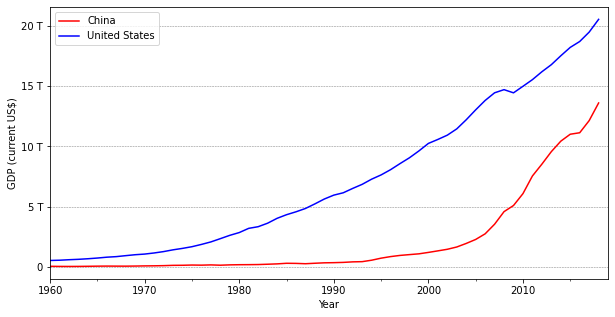

In [6]:
plot_indicator_line("NY.GDP.MKTP.CD")

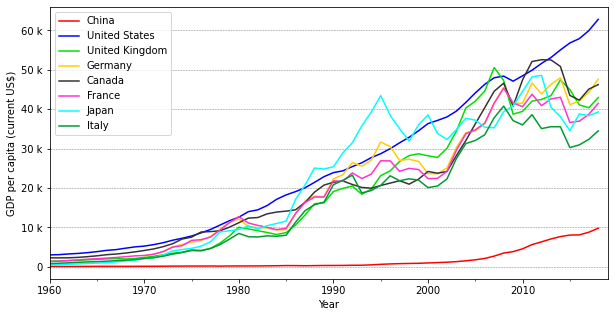

In [7]:
g7_and_china = ["CHN", "USA", "GBR", "DEU", "CAN", "FRA", "JPN", "ITA"]

plot_indicator_line("NY.GDP.PCAP.CD", countries=g7_and_china)

To determine the extent of the economic downturns we look at the percentage change in GDP for each of the above countries. The period we choose is from 1995 to the current day. This was chosen because it includes various economic downturns including the 2008 sub-prime mortgage crisis, the 2000 dot-com bubble, the 1997 Asian economic downturn leading to a global 'mini crash', along with the recovery periods for each.

Above we see the GDP for the US has consistently been greater than China's since data was first recorded.

We also see that just before 2010 the US saw a contraction in its GDP per capita. This is likely due to the sub-prime mortgage crisis which occured in 2008 and plunged many of the worlds economies into recession. We see that China saw little disruption to its GDP during this period, compared to the US.

To investigate this further, we plot the GDP per capita (to ensure similar scales) for both China and the US along with the other G7 countries. The G7 is a group of 7 of the largest advanced economies in the world which represents 58% of the global net wealth (the G7 includes the US). Plotting each G7 country with the US and China we see all countries aside from China saw some form of significant ecomonic contraction around the period of 2008-2009 when the crisis was at its peak.

This suggests China is somewhat economically independent of western economies.

In [8]:
# 1995-2018
gdp_diff_years = list(map(lambda x: str(x), range(1994, 2018 + 1)))

table_indicator_change("NY.GDP.MKTP.CD", countries=g7_and_china, years=gdp_diff_years)

GDP (current US$) (year-over-year change in %)


,China,United States,United Kingdom,Germany,Canada,France,Japan,Italy
1995,30.164059,4.837403,17.632302,17.265549,4.478565,14.857573,11.046924,6.863559
1996,17.588890,5.672608,5.499056,-3.424392,4.058523,0.286075,-11.293643,11.728008
1997,11.329390,6.248295,10.154276,-11.422789,3.862489,-9.515634,-8.667865,-5.375305
1998,7.013193,5.657367,5.842810,1.220673,-3.218424,3.456834,-8.657898,2.268571
1999,6.312094,6.265667,1.952950,-2.000305,7.006931,-0.695970,13.132493,-1.419529
2000,10.726681,6.455227,-1.461168,-11.441905,9.793379,-8.736062,7.133608,-8.641523
2001,10.570783,3.213664,-1.059856,0.049507,-0.796946,1.043597,-11.948298,2.026784
2002,9.792050,3.351008,8.793057,6.404829,2.929317,8.559702,-4.378437,8.885893
2003,12.902516,4.771441,15.048965,20.666129,17.736211,23.167854,8.032380,23.879010
2004,17.771558,6.593377,17.725739,12.541794,14.659002,14.955966,8.311273,14.552727


The most striking observation from this table is the relentless growth of China's economy. From 1995 to the current time there has been a constant economic expansion with 3 separate years seeing around 30% growth in GDP. The US also saw a period of almost continuos expansion during this period but to a lesser lagnitude than China.

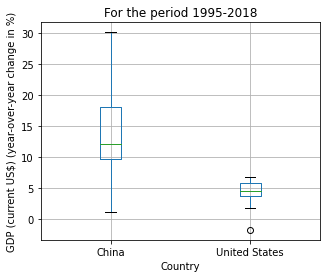

In [9]:
boxplot_indicator_change("NY.GDP.MKTP.CD", years=gdp_diff_years, figsize=(5, 4))

Plotting year-over-year (percentage) change of GDP illustrates the stark difference of the nations' GDP growth statistics.

The comparatively smaller range of the United States' year-over-year growth make sense given the context. The US — a well-established gobal superpower — sees a generally slower but more consistent growth of GDP. Conversely, China's smaller economy saw a a much more volatile period of rapid growth seeing expansion anyhere from 1% to 30% each year.

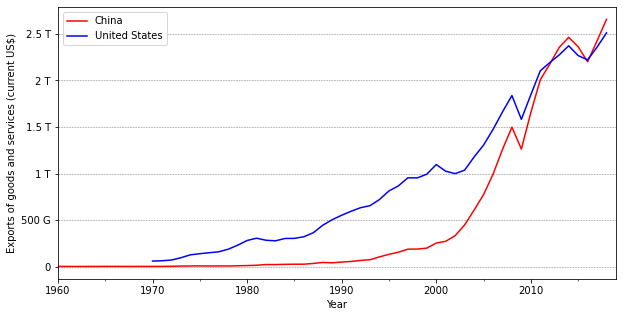

In [10]:
plot_indicator_line("NE.EXP.GNFS.CD")

Historically the US has strong and rapidly growing exports of goods but in recent years China has begun to outpace the US in this front. This is likely due to the introduction of certain capitalist principles in China and the explosion of the tech sector.

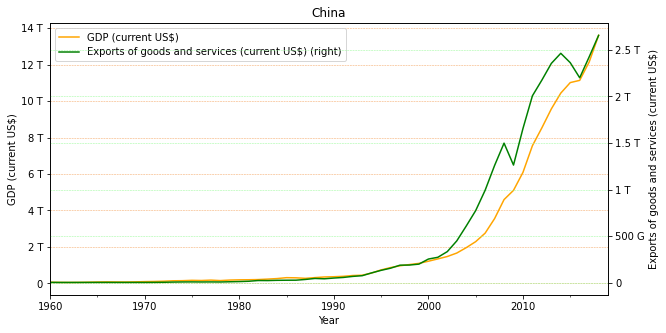

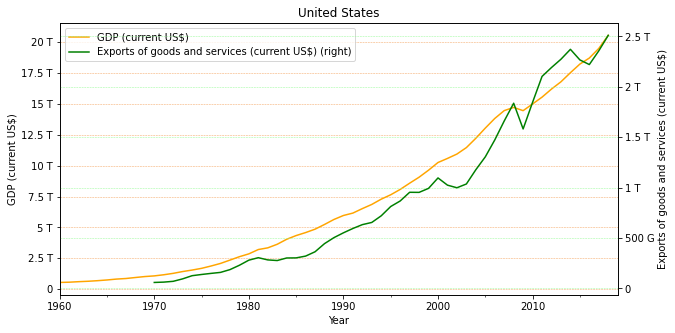

In [12]:
plot_indicator_comparison("NY.GDP.MKTP.CD", "NE.EXP.GNFS.CD", country="CHN")
plot_indicator_comparison("NY.GDP.MKTP.CD", "NE.EXP.GNFS.CD", country="USA")

## Military expenditure

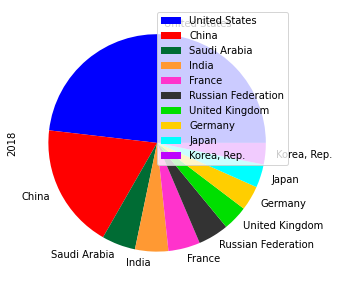

In [13]:
(mil_exp_ind_name, top_mil_exp_df) = get_indicator_top_values("MS.MIL.XPND.CD", n=10, year="2018")

top_mil_exp_df.plot.pie(y="2018", figsize=(8,5), colors=[COLOR_DICT.get(x, '#333333') for x in top_mil_exp_df.index])

In [14]:
print(mil_exp_ind_name)

formatted_mil_exp_df = top_mil_exp_df
formatted_mil_exp_df['2018'] = formatted_mil_exp_df.apply(lambda x: "{:,.0f}".format(x['2018']), axis=1)
formatted_mil_exp_df

Military expenditure (current USD)


,Rank,2018
Country Name,,
United States,1,"648,798,273,000"
China,2,"249,996,900,635"
Saudi Arabia,3,"67,554,666,667"
India,4,"66,510,289,108"
France,5,"63,799,676,593"
Russian Federation,6,"61,387,546,980"
United Kingdom,7,"49,997,192,521"
Germany,8,"49,470,627,811"
Japan,9,"46,617,954,864"


The US and China rank as the countries with the highest and second-highest military spending respectively with the US military budget being more than double that of China's.

The budget of the american and chinese military overshadows all other nations with China's budget being more than 3 times larger than the next largest neighbour, Saudi Arabia. The US budget is nearly 10 times larger than Saudi Arabia's and is almost equal to the budget of the next 9 largest countries combined.

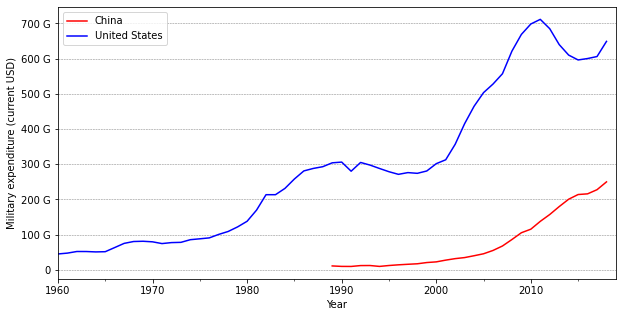

In [15]:
plot_indicator_line("MS.MIL.XPND.CD")

We choose a period of 1989-2018 to compare data points for the US and China. Before that time China has not published any official figures on its total military expenditure.

Military expenditure for the period of 1989-2018 was considerably higher for the US with two significant increases. The first increase, peaking around 1990, can likely be attributed to the Cold War and the escalating tensions between the US and Soviet Union. In 1991 the Soviet Union was dissolved reducing the hostility between the nations and resulting in a contraction of the military budget. The second increase which peaked around 2010 is likely caused by the US "War on Terror" -- which included the invasion of Iraq and Afghanistan -- following the 9/11 attacks in 2001. This war would become the longest and 2nd most expensive war in US history.

In comparison China has seen a relatively steady and consistent growth in military spending. While China has been involved in various conflicts in this time, it hasn't participated in anything on the scale of the US' Cold War or the War on Terror.

In [16]:
# the only years with data available for China
mil_exp_years = list(map(lambda x: str(x), range(1989, 2018 + 1)))

table_indicator_change("MS.MIL.XPND.CD", years=mil_exp_years)

Military expenditure (current USD) (year-over-year change in %)


,China,United States
1990,-11.561160,0.685664
1991,-1.303309,-8.452167
1992,24.781474,8.865398
1993,1.262973,-2.459191
1994,-20.088622,-3.218014
1995,25.427800,-3.194832
1996,15.524156,-2.667685
1997,10.586070,1.808288
1998,8.836275,-0.740794
1999,19.964362,2.439496


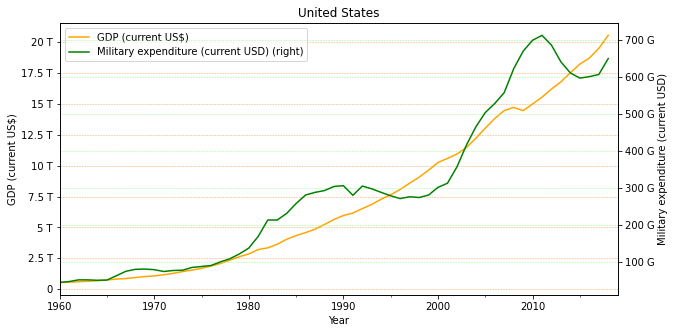

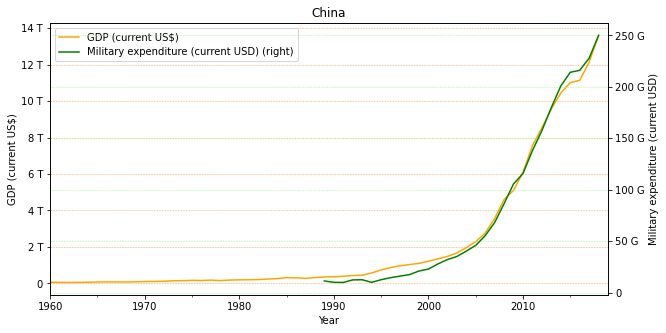

In [17]:
plot_indicator_comparison("NY.GDP.MKTP.CD", "MS.MIL.XPND.CD", country="USA")
plot_indicator_comparison("NY.GDP.MKTP.CD", "MS.MIL.XPND.CD", country="CHN")

A further interesting comparison we can make is between GDP and military expenditure. The US saw two significant surges in military spending, as mentioned earlier, due to the Cold War and the War on Terror. The act of war (or the threat of its impending arrival) is expensive and requires large increases in spending that may not necessarily correlate with the economic growth of the country.

Looking at China was can see military expenditure is very closely correlated with GDP. This suggests that China is experiencing more of a 'natural' growth of its military, powered by its growing economic and political influence internationally. Having said that, this does not exclude the possibility of war as a motivator for China. The US and China are very different both in terms of ideology and their strategic goals around the world.